In [1]:
import os
n_jobs = 12
os.environ["OMP_NUM_THREADS"] = str(n_jobs)
import joblib
import click
import json
import time

import itertools
import collections.abc
import sys
from tqdm.notebook import tqdm
# !{sys.executable} -m pip install qcircuit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_ibm_runtime import Batch
from qiskit_ibm_runtime import exceptions
# from qiskit_machine_learning.optimizers import SPSA, Minimizer


from joblib import dump, load
from QiskitRegressor import QiskitRegressor

In [2]:
def mitarai(quantumcircuit,num_wires,paramname='x'):
    # encoding as proposed by Mitarai et al.
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        quantumcircuit.ry(np.arcsin(features[feature_idx * 2]), i)
        quantumcircuit.rz(np.arccos(features[feature_idx * 2 + 1] ** 2), i)


def double_angle(quantumcircuit, num_wires,paramname='x'):
    #  creates a circuit that encodes features into wires via angle encoding with an RY then RZ gate
    #  the features are encoded 1-1 onto the qubits
    #  if more wires are passed then features the remaining wires will be filled from the beginning of the feature list
    num_features = num_wires
    features = ParameterVector(paramname,num_features*2)
    for i in range(num_wires):
        feature_index = i % num_features
        quantumcircuit.ry(features[feature_index], i)
        quantumcircuit.rz(features[feature_index], i)

def entangle_cnot(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cx(i, 0)
        else:
            quantumcircuit.cx(i, i+1)


def entangle_cz(quantumcircuit,num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            quantumcircuit.cz(i, 0)
        else:
            quantumcircuit.cz(i, i+1)


def HardwareEfficient(quantumcircuit,num_wires,paramname='theta'):
    parameters = ParameterVector(paramname,num_wires*3)
    for qubit in range(num_wires):
        quantumcircuit.rx(parameters[qubit * 3], qubit)  
        quantumcircuit.rz(parameters[qubit * 3 + 1], qubit)  
        quantumcircuit.rx(parameters[qubit * 3 + 2], qubit)  
    entangle_cnot(quantumcircuit,num_wires)



In [3]:
# def circuit(nqubits):
#     qc = QuantumCircuit(nqubits)
#     mitarai(qc,nqubits)
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     mitarai(qc,nqubits,paramname='x1')
#     entangle_cz(qc,nqubits)
#     qc.barrier()
#     HardwareEfficient(qc,nqubits)
#     qc.barrier()
#     return qc


def circuit(nqubits,RUD=1,AL=1):
    qc = QuantumCircuit(nqubits)
    for i in range(RUD):
        double_angle(qc,nqubits,paramname=f'x{i}')
        qc.barrier()
        for j in range(AL):        
            HardwareEfficient(qc,nqubits,paramname=f'theta{i}_{j}')
            qc.barrier()
    return qc

In [4]:

top=os.getcwd()
with open(os.path.join(top,'5_DDCC_train.bin'),'rb') as f:
    ddcc_train = joblib.load(f)

with open(os.path.join(top,'5_DDCC_test.bin'),'rb') as f:
    ddcc_test = joblib.load(f)

with open(os.path.join(top,'5_DDCC_scaler.bin'),'rb') as f:
    ddcc_scaler = joblib.load(f)

X_ddcc_train, y_ddcc_train = ddcc_train['X'],ddcc_train['y']
X_ddcc_test, y_ddcc_test = ddcc_test['X'],ddcc_test['y']

X_ddcc_train = X_ddcc_train.reshape(-1,64,5)[0:4]
X_ddcc_test = X_ddcc_test.reshape(-1,64,5)[0:4]
y_ddcc_train = y_ddcc_train.reshape(-1,64)[0:4]
y_ddcc_test = y_ddcc_test.reshape(-1,64)[0:4]


# X_train, y_train = X_ddcc_train, y_ddcc_train
# X_test, y_test = X_ddcc_test, y_ddcc_test
X_train, y_train = X_ddcc_train, y_ddcc_train
X_test, y_test = X_ddcc_test, y_ddcc_test

# X_train = [X_train[i:i+4] for i in range(0,len(X_train),4)]
# X_test = [X_test[i:i+4] for i in range(0,len(X_test),4)]
scaler = ddcc_scaler

# print(len(X_train),X_train[0].shape,X_train[-1].shape)
print(y_train.shape, y_test.shape)

(4, 64) (4, 64)


/home/ubuntu/miniconda3/envs/qml/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
num_qubits = 5
RUD = 1
AL = 5

In [6]:
optimization_level = 2
shots = 3072
# shots = 1024.0 * 1
resilience_level = 1

In [7]:
optimization_level = int(optimization_level)
shots = int(shots)
# shots = 1024.0 * 1
resilience_level = int(resilience_level)

In [8]:
# 
qc = circuit(num_qubits,RUD,AL)

observables_labels = ''.join(['I']*(num_qubits-1))+"Z"

In [9]:
model = QiskitRegressor(qc,
                        num_qubits,
                        AL,
                        RUD,
                        'real', #'fake',
                        observables_labels,
                        verbose=True,
                        instance='pinq-quebec-hub/univ-toronto/default',
                        iterations=10,
                        n_jobs=n_jobs,
                        parameterpath='./state_vector_parameters.bin')
model.fit(X_train,y_train)



./state_vector_parameters.bin
Parameters loaded
[-3.12796163  2.20923479 -2.15356047 -0.20272741  0.45787692 -2.84003282
  3.10217594  2.21913693  1.17861986 -0.90578323  0.60926206  1.08842887
  1.30878757 -1.83754319  1.05930109  2.92869346 -0.45472001 -0.53390713
 -1.94943806  0.96644527  1.83382822  2.59903043 -1.27248814 -0.24476434
 -2.55148033 -2.19211736  3.18233718  2.48878626 -0.54848978 -2.79958123
  1.58113557 -0.03487004 -2.40488905  2.23078263  1.30281402 -0.52182491
  0.98516107 -1.73367864 -0.3479275   2.34534114 -0.16352274  0.48817249
  2.62697457  0.99203839  2.93104541  2.76133689  2.87866402 -2.78879742
  0.17609349 -0.35129591  1.53780447  2.8570011  -0.27269594 -2.34909155
  2.65752438 -3.00081876  0.74611123 -0.85515604 -1.61543159  2.91095663
 -1.70506496 -1.62327844 -2.60549583  2.14665867 -2.26107756  2.14784551
  2.05804096  1.67840528  2.48059465  2.74975017  1.74108432  1.59959627
 -1.80899923 -2.10894248  1.38774611]


[SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])]
<IBMBackend('ibm_quebec')>


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.8740 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 521586.9614 s
Iters. done: 1 Current cost: 0.14134139301672408 Accuracy: -0.5624941342939775 Time: 521606.920142211


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.8075 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 212.6096 s
Iters. done: 2 Current cost: 0.14218567441274998 Accuracy: -0.5718274562658923 Time: 235.54732989892364


Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.3607 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 140.4540 s
Iters. done: 3 Current cost: 0.13907878802458257 Accuracy: -0.5374815958366335 Time: 159.90675348043442


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.2218 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 131.3001 s
Iters. done: 4 Current cost: 0.13829778390184777 Accuracy: -0.5288477884672089 Time: 149.60484121739864


Mappings: 0it [00:00, ?it/s]

Submitted to device in 18.3087 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 124.1267 s
Iters. done: 5 Current cost: 0.13350238453663807 Accuracy: -0.475835834786728 Time: 142.519933976233


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1641 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.6425 s
Iters. done: 6 Current cost: 0.12585785164643903 Accuracy: -0.391327414815658 Time: 141.89291306957603


Mappings: 0it [00:00, ?it/s]

Submitted to device in 21.3720 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 119.1683 s
Iters. done: 7 Current cost: 0.13112227713760216 Accuracy: -0.44952433628930444 Time: 140.62248280644417


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.1212 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.3014 s
Iters. done: 8 Current cost: 0.12896655187286146 Accuracy: -0.42569332677811245 Time: 141.48173743858933


Mappings: 0it [00:00, ?it/s]

Submitted to device in 20.7754 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 121.0907 s
Iters. done: 9 Current cost: 0.13097354439137698 Accuracy: -0.44788013257378867 Time: 141.95334692299366


Mappings: 0it [00:00, ?it/s]

Submitted to device in 17.6390 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 122.8965 s
Iters. done: 10 Current cost: 0.12352531787757517 Accuracy: -0.3655418310308629 Time: 140.62865361571312


In [10]:
y_train_pred = model.predict(X_train,iters='trainpred')
y_test_pred = model.predict(X_test,iters='testpred')

Mappings: 0it [00:00, ?it/s]

Submitted to device in 19.7963 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 120.3605 s


Mappings: 0it [00:00, ?it/s]

Submitted to device in 22.1127 s


Running batch:   0%|          | 0/1 [00:00<?, ?it/s]

Predicted in 236.7272 s


In [11]:
unscaled_y_train = ddcc_scaler.inverse_transform(y_train)
unscaled_y_train_pred = ddcc_scaler.inverse_transform(y_train_pred)

unscaled_y_test = ddcc_scaler.inverse_transform(y_test)
unscaled_y_test_pred = ddcc_scaler.inverse_transform(y_test_pred)

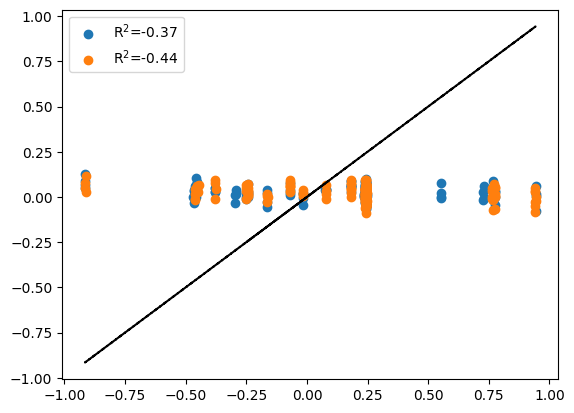

In [12]:
plt.scatter(y_train.flatten(),y_train_pred.flatten(),label="R$^{2}$="+f"{r2_score(y_train.flatten(),y_train_pred.flatten()):.2f}")
plt.plot(y_train.flatten(),y_train.flatten(),'k--')
plt.scatter(y_test.flatten(),y_test_pred.flatten(),label="R$^{2}$="+f"{r2_score(y_test.flatten(),y_test_pred.flatten()):.2f}")
plt.legend()
plt.show()

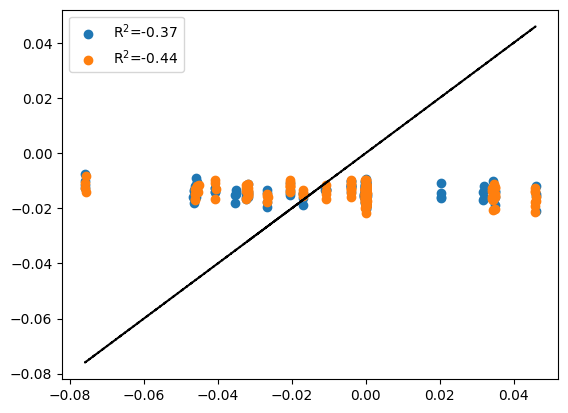

In [13]:
plt.scatter(unscaled_y_train.flatten(),unscaled_y_train_pred.flatten(),label="R$^{2}$="+f"{r2_score(unscaled_y_train.flatten(),unscaled_y_train_pred.flatten()):.2f}")

plt.plot(unscaled_y_train.flatten(),unscaled_y_train.flatten(),'k--')
plt.scatter(unscaled_y_test.flatten(),unscaled_y_test_pred.flatten(),label="R$^{2}$="+f"{r2_score(unscaled_y_test.flatten(),unscaled_y_test_pred.flatten()):.2f}")
plt.legend()
plt.show()

In [14]:
# Goal, error handling: RuntimeJobFailureError: 'Unable to retrieve job result. Job estimator_cv61fk0tqh9s73cvpdeg_f0fa_4 cancelled due to compilation timeout 8100000000000.'
